#Notebook Overview
This notebook will compare 4 inpainting techniques qualitatively :
* SIREN
* Navier-Stokes
* Telea
* Biharmonic

All inpainting was done using Temperature Thresholding mask to detect the fence (chosen based on previous results).

For quantitive comparison against an artifical image see notebook 4: compare's SIREN versus Biharmonic inpainting.

In [1]:
#Importing drive, not necessary if not using google colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#All neccessary imports
import torch
import pandas as pd
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import matplotlib.pyplot as plt
import time

import skimage
from skimage import exposure
from skimage.restoration import inpaint

from torch.utils.data import Dataset, DataLoader
import cv2

In [3]:
#Example image (called Inpainting_image_to_Test)
csv_file = "/content/drive/MyDrive/Final Code/Inpainting_image_to_Test.csv"

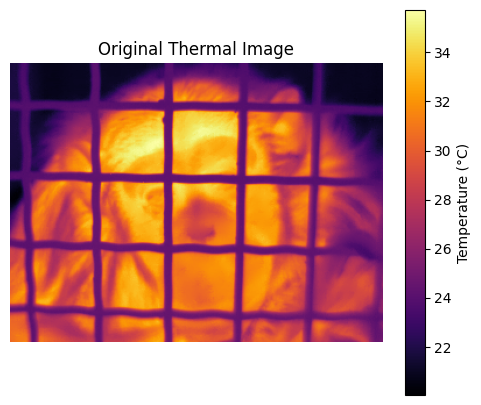

In [4]:
#plotting our original image/ inpainting image to test:
thermal_image = pd.read_csv(csv_file, header=None).values.astype(np.float32)

plt.figure(figsize=(6, 5))
img = plt.imshow(thermal_image, cmap='inferno')
plt.title('Original Thermal Image')
plt.axis('off')

cbar = plt.colorbar(img)
cbar.set_label("Temperature (°C)")
plt.savefig("thermal_fence.pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

#Temperature Thresholding Fence Detection

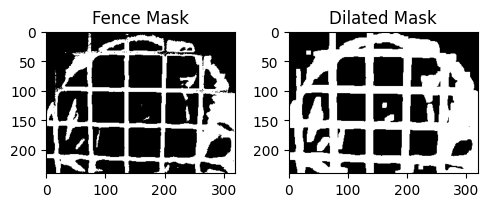

In [5]:
#Before inpainting we must segment fence
#Using temeprature to detect fence

lower_threshold = 24
upper_threshold = 28

fence_mask = (thermal_image >= lower_threshold) & (thermal_image <= upper_threshold)
#Normalise
fence_mask_norm = fence_mask.astype(np.uint8) * 255
#Dilate
kernel = np.ones((3, 3), dtype=np.uint8)
dilated_mask = cv2.dilate(fence_mask_norm, kernel, iterations=3)

non_fence_mask = (dilated_mask == 0).astype(np.float32)#necessary for SIREN (need to know what is not fence)


plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(fence_mask, cmap='gray')
plt.title('Fence Mask')

plt.subplot(1, 2, 2)
plt.imshow(dilated_mask, cmap='gray')
plt.title('Dilated Mask')

plt.tight_layout()
plt.show()


In [6]:
######## Code DIRECTLY copied from original papper ############
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations


def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [7]:
####### The rest of the Code has been adapted/changed from Original papper ###########

#Code below defines 2 functions that load, pre-process, and make into dataset our csv temperature frame
#It normalises it to 0-1, resizes it fit the network, and make it's into a tensor.

def preprocess_thermal_image(csv_file_path, sidelength):
    #Load CSV frame and make into NumPy array
    thermal_data = np.genfromtxt(csv_file_path, delimiter=',')
    #Normalize csv to range 0-1 (needed for SIREN)
    thermal_data = (thermal_data - np.min(thermal_data)) / (np.max(thermal_data) - np.min(thermal_data))

    #Resize the image to 256 before entering network
    thermal_data_resized = np.array(Image.fromarray((thermal_data * 255).astype(np.uint8)).resize((sidelength, sidelength)))

    #Convert to PIL Image for torchvision transforms
    thermal_image = Image.fromarray(thermal_data_resized)

    #Define transformations/ pre-processing
    transform = Compose([
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    #Apply transformations
    img = transform(thermal_image)
    return img

class ThermalImageDataset(Dataset):
    def __init__(self, csv_file_path, sidelength):
        super().__init__()
        img = preprocess_thermal_image(csv_file_path, sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError
        return self.coords, self.pixels

#Load data and create dataset (That has been pre-processed correctly)
csv_file_path = csv_file
sidelength = 256
thermal_dataset = ThermalImageDataset(csv_file_path, sidelength)
dataloader = DataLoader(thermal_dataset, batch_size=1, pin_memory=True, num_workers=0)


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


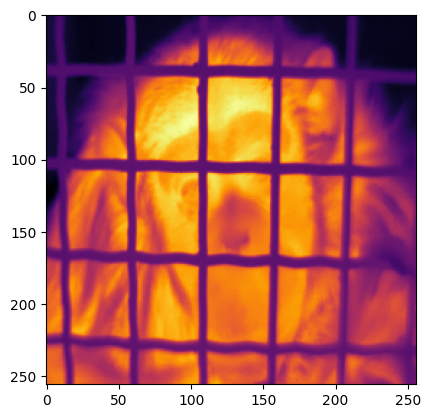

In [8]:
#Seeing if frame is being pre-processed correctly
test_img = preprocess_thermal_image(csv_file_path, sidelength)
#after that to see image have to permute: (height, width, channels)
plt.imshow(test_img.permute(1, 2, 0), cmap = "inferno")
plt.show()

In [9]:
#Initalise SIREN network
#Note:Using gpu to accelerate training
img_siren = Siren(in_features=2, out_features=1, hidden_features=256, hidden_layers=3, outermost_linear=True).cuda()

In [10]:
total_steps = 1000 #1000 epochs
steps_til_summary = 10 #every 10 epochs report progress

#adam optimiser with learning rate of 0.0001
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

#Loads in our single batch from dataloader
coordin_grid, pixel_value = next(iter(dataloader))
coordin_grid, pixel_value = coordin_grid.cuda(), pixel_value.cuda()

for epoch in range(total_steps):
    #Asks SIREN to guess pixels based on coordinates (Random noise at the start)
    model_output_pixels, coords = img_siren(coordin_grid)
    #Reshape: linear output (flat vector) is reshaped into a 2D image of size 256
    model_output_reshaped = model_output_pixels.view(sidelength, sidelength)

    #Get's the part of the frame that are not fenced (non_fence_mask)
    #and re-sizes it to 256 so it matches the SIREN input image
    non_fence_mask_resize = cv2.resize(non_fence_mask, (sidelength, sidelength), interpolation=cv2.INTER_NEAREST)
    #model’s output is masked so that only predictions for non-fenced regions are considered
    no_Fence_output_model = model_output_reshaped * torch.tensor(non_fence_mask_resize, dtype=torch.float32).cuda()
    #Only the non-fenced area pixel values
    non_fenced_pixels_groundtruth = pixel_value.view(sidelength, sidelength) * torch.tensor(non_fence_mask_resize, dtype=torch.float32).cuda()
    #Loss computed only over the non-fenced regions (MSE)
    loss = ((no_Fence_output_model - non_fenced_pixels_groundtruth) ** 2).mean()

    if not epoch % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (epoch, loss))
        img_grad = gradient(model_output_pixels, coords)
        img_laplacian = laplace(model_output_pixels, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output_pixels.cpu().view(256,256).detach().numpy(), cmap="gray")
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy(), cmap="gray")
        axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy(), cmap="gray")
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

Output hidden; open in https://colab.research.google.com to view.

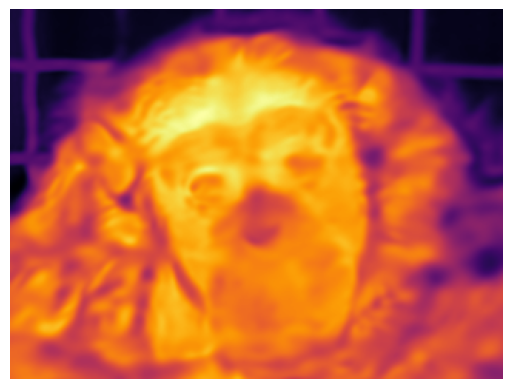

In [11]:
#Saving the results from Siren as numpy array
siren_output = model_output_reshaped.detach().cpu().numpy()

#Resize back to orginal
##Siren: 256 x 256
##Original is 320 x 240
original_size = (320, 240)
resized_output = cv2.resize(siren_output, original_size, interpolation=cv2.INTER_CUBIC)

#Normalize to 0–255
norm_siren_output = cv2.normalize(resized_output, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

plt.imshow(norm_siren_output, cmap='inferno')
plt.axis('off')
plt.show()

plt.imsave("Siren_Temp_approach_500_FINAL.pdf", norm_siren_output, cmap='inferno')
#cv2.imwrite("Siren_Temp_approach_BEST.png", resized_output_uint8)


#Navier-Stokes

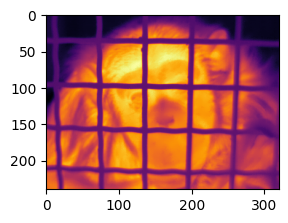

In [12]:
#To avoid notebook cell confounds
#Re-doing intialisation

csv_file = "/content/drive/MyDrive/Final Code/Inpainting_image_to_Test.csv"
thermal_image = pd.read_csv(csv_file, header=None).to_numpy()
normalized_thermal_image = cv2.normalize(thermal_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
plt.figure(figsize=(3, 3))
plt.imshow(normalized_thermal_image, cmap='inferno')
plt.show()

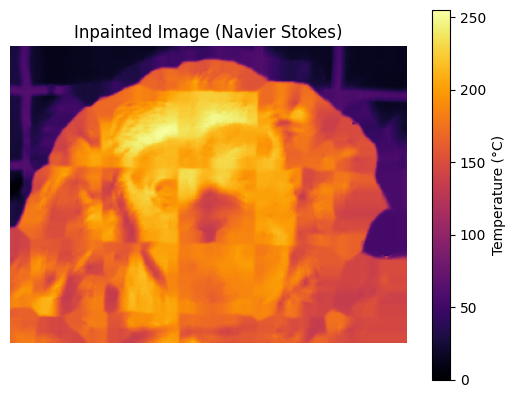

In [13]:
#Dilated mask is from earlier cell
inpainted_navier = cv2.inpaint(normalized_thermal_image,dilated_mask, 5, cv2.INPAINT_NS)
plt.imshow(inpainted_navier, cmap='inferno')
plt.colorbar(label='Temperature (°C)')
plt.title('Inpainted Image (Navier Stokes)')
plt.axis('off')
plt.imsave("Navier-Stokes_inpaint.png", inpainted_navier, cmap='inferno')
plt.show()


#Telea Inpainting

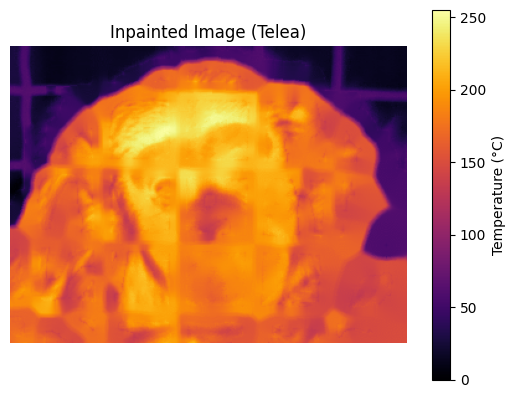

In [14]:
#Trying telea
inpainted_telea = cv2.inpaint(normalized_thermal_image,dilated_mask, 5, cv2.INPAINT_TELEA)
plt.imshow(inpainted_telea, cmap='inferno')
plt.colorbar(label='Temperature (°C)')
plt.title('Inpainted Image (Telea)')
plt.axis('off')
plt.imsave("Telea_inpaint.png", inpainted_telea, cmap='inferno')
plt.show()


#Biharmonic Inpainting

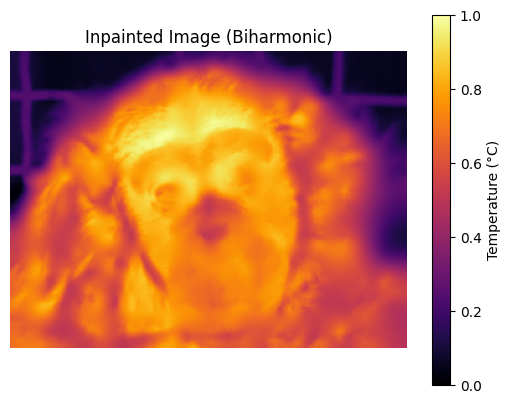

In [15]:
#Testing biharmonic
inpaint_biharmonic = inpaint.inpaint_biharmonic(normalized_thermal_image,dilated_mask)
plt.imshow(inpaint_biharmonic, cmap='inferno')
plt.colorbar(label='Temperature (°C)')
plt.title('Inpainted Image (Biharmonic)')
plt.axis('off')
plt.imsave("Biharmonic_inpaint.png", inpaint_biharmonic, cmap='inferno')
plt.show()